# EECS16B HW10: Orthonormalization for Model Order Selection

In [1]:
# Required imports
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.linalg import solve_triangular
%matplotlib inline

np.random.seed(0)

In [2]:
# Generate FIR dataset
def FIR_generate_dataset():
    m_train = 4000 # number of train data
    m_valid = 4000 # number of validation data
    N = 250 # true order

    m = m_train + m_valid # total data size

    # parameters
    p = np.random.normal(loc= 0.0, scale=1.0, size=(N,))

    # inputs
    # assume all the previous input u[-1], u[-2], ... are zero.
    u = np.random.normal(loc= 0.0, scale=1.0, size=(m,))
    
    # generate data trace

    y = []
    for i in range(m):
        # u_tmp will hold [u[i-1], ... ,u[i-(N-1)], u[i-N]]

        if i < N :
            u_tmp = u[:i]
            u_tmp = u_tmp[::-1]
            y_tmp = np.dot(u_tmp, p[:i])
        else:
            u_tmp = u[(i-N):i]
            u_tmp = u_tmp[::-1]
            y_tmp = np.dot(u_tmp, p)

        noise = y_tmp * np.random.normal(0, 0.1)
        # noise = 0

        y.append(y_tmp+ noise)

    y = np.array(y)

    data_u = u[:m_train]
    data_y = y[:m_train]

    data_u_valid = u[m_train:]
    data_y_valid = y[m_train:]

    return data_u, data_y, data_u_valid, data_y_valid

data_u, data_x, data_u_valid, data_x_valid = FIR_generate_dataset()

# save data generated
np.save("data_u.npy", data_u)
np.save("data_x.npy", data_x)
np.save("data_u_valid.npy", data_u_valid)
np.save("data_x_valid.npy", data_x_valid) 

In [3]:
# load training data
data_u = np.load("data_u.npy")
data_x = np.load("data_x.npy")
# load validation data
data_u_valid = np.load("data_u_valid.npy")
data_x_valid = np.load("data_x_valid.npy")

We are given input data $u$ and $x$ that satisfies
$$ x[i+1] = b_1 u[i] + b_2 y[i-1] + \cdots + b_N y[i-(M-1)] + w[i] $$
Where $w[i]$ is a bounded noise term in our observations $x[i+1]$.

Our goal is to find unknown parameters $\vec{p}_M= \begin{bmatrix}b_1, b_2, \cdots, b_M\end{bmatrix}^\top$, as well as the optimal value of $M$.

Note that we have two sets of data: [data_u, data_x] and [data_u_valid, data_x_valid], both sampled for 4000 timesteps. The former will be used to fit the parameters, and the latter will be used for evaluating the parameters. We call them the training dataset and validation dataset respectively.

In order to solve for the parameters of the FIR filter, we form the given data $u$ and $x$ into a matrix equation. $D_M\vec{p}_M\approx\vec{s}_M$

The function `FIR_form_matrix_equation` returns $D_M$ and $\vec{s}_M$ for a value of $M$ and $M_\mathrm{max}$ where $M_\mathrm{max}$ is the maximum order we are considering for our system. The reason for this variable is to insure uniformity of the length of the column vectors we have in our $D_M$ matrices for different model orders we are evaluating.

In [4]:
def FIR_form_matrix_equation(data_u, data_x, M, Mmax):
    # Returns D matrix and s matrix for a certain model order M
    L = len(data_x)
    D = np.zeros((L-Mmax,M))
    s = data_x[M:L-Mmax + M]
    for i in range(L-Mmax):
        D[i,:] = data_u[i:i+M][::-1] 
    return D, s

In [5]:
M, Mmax = 10, 500
D_10, s_10 = FIR_form_matrix_equation(data_u, data_x, M, Mmax)
print('The shapes of the data matrix and measurement data for N=10 and Nmax=500')
print(D_10.shape, s_10.shape)

The shapes of the data matrix and measurement data for N=10 and Nmax=500
(3500, 10) (3500,)


The function `LS` is a wrapper function for the built-in `numpy` least squares function to get the solution for $Dp\approx s$.

In [6]:
def LS(D, s):
    # compute least square solution P of Dp = s
    p,_,_,_= np.linalg.lstsq(D, s,rcond=None)
    return p

In [7]:
p_10 = LS(D_10, s_10)
print('Estimated parameters for N=10, Nmax=500\n',p_10)

Estimated parameters for N=10, Nmax=500
 [ 1.38787565  0.35199264  0.68451636  2.17039086  2.24676358 -0.87879914
  1.01678741 -0.34494213 -0.36532446  0.28928627]


The function `calculate_LS_error` computes the error between the predicted output $\vec{s}_{pred}$ and $\vec{s}$ in a average square error sense from some parameters $\vec{p}$.

In [8]:
def calculate_LS_error(D, s, p):
    # compute least squares error
    s_pred = D @ p
    error = (np.mean((s - s_pred)**2))**0.5

    return error

In [9]:
error = calculate_LS_error(D_10, s_10, p_10)
print('Error for model order M=10:',error)

Error for model order M=10: 14.654073392043445


# Part (a)

In order to find the optimal model order and the model parameters, we loop over computing the least squares solution to $D_M\vec{p}_M \approx \vec{s}_M$ for possible orders $M=1,2, ... ,500$ with $M_\mathrm{max} = 500$.

**Comment on the optimal order $M$ from the error plot generated from running the code below.**

Note that after some value of $M$ you will notice that while the training error decreases, the validation error gradually increases. 
This is because when the number of parameters $M$ is too big, the model has unnecessary parameters in it as compared to the real pattern that needs to be learned. While in an ideal world, you'd hope that those additional parameters would be fit to zero, that is not what happens with least-squares. They get small nonzero values because of the idiosyncracies of the noise. We call this phenomena overfitting. When overfitting occurs, one may observe validation error increasing because the parameters starts to fit information in the training data that the validation data does not have.
We can avoid overfit by selecting the simplest order where the validation error is smallest.

The optimal case can be found by picking the $M$ right before the validation error increases, as this will be the $M$ for which we have minimum validation error.

In [10]:
# helper function for plotting errors
def plot_errors(Ms, train_errors, validation_errors):
    plt.plot(Ms, train_errors, label="train")
    plt.plot(Ms, validation_errors, label="validation")
    plt.xlabel("Order")
    plt.ylabel("Mean Square Error")
    plt.legend()
    plt.gcf().set_dpi(100)
    plt.show()

# Straightforward attempt to solve the problem.
def FIR_solve(data_u, data_x, data_u_valid, data_x_valid, Ms, Mmax):
    t0 = time.time()

    train_errors = []
    validation_errors = []
    
    # Initialize data matrices. No reason to pay this cost repeatedly
    D, s = FIR_form_matrix_equation(data_u, data_x, Mmax, Mmax)
    D_valid, s_valid = FIR_form_matrix_equation(data_u_valid, data_x_valid, Mmax, Mmax)

    for M in Ms:
        
        # Solve the least squares problem just for M parameters by only using the first M columns. 
        p = LS(D[:,:M], s)

        # calculate training error
        train_error = calculate_LS_error(D[:,:M], s, p)
        train_errors.append(train_error)

        # calculate validation error 
        validation_error = calculate_LS_error(D_valid[:,:M], s_valid, p)
        validation_errors.append(validation_error)

    t1 = time.time()
    print(f"FIR_solve: total time {t1-t0:.3f}sec")

    plot_errors(Ms, train_errors, validation_errors)

FIR_solve: total time 88.905sec


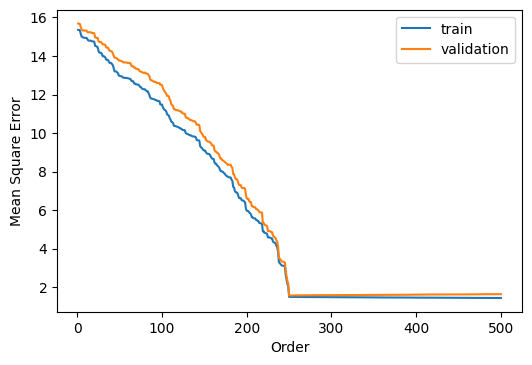

In [11]:
# If you are on a local machine with decent resources, when running this block, change Mmax to 750 or 1000 to see how the run time fares.
Mmax = 500
Ms = list(range(1,Mmax + 1))
FIR_solve(data_u, data_x, data_u_valid, data_x_valid, Ms, Mmax)

## Part (b)
In this part, we will speed up the nested least squares solutions by leveraging the QR decomposition.
The QR decomposition of a matrix $D$ is the factorization of $D$ into an orthonormal matrix $Q$ and upper-triangular matrix $R$. $Q$ a matrix that would be output by running Gram-Schmidt on $D$.


The nested nature of the subspaces and the upper-triangular nature of $R$ lets us reuse a lot of work. In the orthonormal basis provided by the $Q$, the solution to the least-squares problem of order $M+1$ is just the solution of order $M$, with one additional parameter. Furthermore, because of the upper-triangular nature of $R$, we can update the values for the learned parameters in the original basis as well without taking inverses for all $R$ of different orders. This is what you need to figure out.



**Complete the function `FIR_solve_fast` to test for order $M=1,2,\dots,500$.**

**Comment on the runtime of this method, comparing the runtime with the least squares case above.**

# Fill in the missing lines

In [13]:
def FIR_solve_fast(data_u, data_x, data_u_valid, data_x_valid, Mmax):
    t0 = time.time()
    
    train_errors = []
    validation_errors = []
    
    # Set up the big data matrices as before
    X, y = FIR_form_matrix_equation(data_u, data_x, Mmax, Mmax)
    X_val, y_val = FIR_form_matrix_equation(data_u_valid, data_x_valid, Mmax, Mmax)
    
    # Something new: now we precompute the QR decomposition for our data matrix
    Q, R = np.linalg.qr(X)
    # We also invert the big R matrix exactly once so we have it available. 
    # Remember what the columns of the inverse mean.
    Rinv = np.linalg.inv(R)
    
    # Now, we can also easily do the projection into the big orthonormal basis
    # This gives us the least-squares solution in the orthonormal coordinates
    # And "prefixes" of this give us the least-squares solutions for lower-order
    # models, just in the orthonormal coordinates
    proj = Q.T @ y
    
    # This sets up the saving of the learned parameters in the original basis. 
    # It is initialized to all zeros since initially, we don't know anything.
    # We want to save all of the parameters for each order we have learned along the way.
    # This is to use the ones that best fit some purpose.
    params = np.zeros((len(y), Mmax))
    params[0,0] = Rinv[0, 0]*proj[0]
    

    # Now we loop through the model orders
    for i in range(Mmax-1):
        p = None
        #### STUDENT CODE START
        
        # FILLIN: Compute the new parameters for the next model order based on the previous model order
        params[:i+2,i+1] = params[:i+2,i] + Rinv[:i+2,i+1]*proj[i+1]
        
        # FILLIN: Evaluate the p used for evaluating training error and validation error
        p = params[:i+1,i]
        
        #### STUDENT CODE END ###
        
        train_error = calculate_LS_error(X[:,:i+1], y, p)
        train_errors.append(train_error)
        validation_error = calculate_LS_error(X_val[:,:i+1], y_val, p)
        validation_errors.append(validation_error)
    p = params[:Mmax,Mmax-1]
    train_error = calculate_LS_error(X[:,:Mmax], y, p)
    train_errors.append(train_error)
    validation_error = calculate_LS_error(X_val[:,:Mmax], y_val, p)
    validation_errors.append(validation_error)
    
    t1 = time.time()
    print(f"FIR_solve_fast: total time {t1-t0:.3f}sec")    

    Ms = list(range(1,Mmax+1))
    plot_errors(Ms, train_errors, validation_errors)

FIR_solve_fast: total time 0.585sec


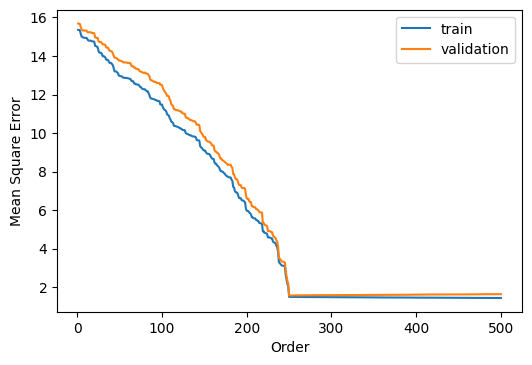

In [14]:
FIR_solve_fast(data_u, data_x, data_u_valid, data_x_valid, 500)